# Global preparations

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:5'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True

# MNIST preparation

Let's read the MNIST dataset and represent it in sparse form

In [2]:
mnist_dataset_dir = 'mnist'

import torchvision.transforms as T

mnist_train_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=True, download=True
)
mnist_test_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=False, download=True
)
mnist_train_data_device = mnist_train_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_test_data_device = mnist_test_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_train_targets_device = mnist_train_dataset.targets.to(device=device)
mnist_test_targets_device = mnist_test_dataset.targets.to(device=device)

mnist_train_dataset = TensorDataset(
    mnist_train_data_device, mnist_train_targets_device
)
mnist_test_dataset = TensorDataset(
    mnist_test_data_device, mnist_test_targets_device
)

In [3]:
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_train_dataset,
    batch_size=10, shuffle=True
)

example_data, example_targets = next(iter(mnist_test_loader))
to_pil_image(example_data[0])

# Layered ANDN network

In [46]:
def uniform_sparsity_mask(H, W, alpha, device):
    return torch.rand(H, W, device=device) < alpha

def normal_sparsity_mask(H, W, alpha, device, sigma=4.0):
    yy, xx = torch.meshgrid(
        torch.arange(H, device=device),
        torch.arange(W, device=device),
        indexing="ij",
    )

    cy = (H - 1) / 2.0
    cx = (W - 1) / 2.0

    # choose spread (std dev) in pixels
    sigma_y = H / sigma
    sigma_x = W / sigma

    p = torch.exp(-0.5 * (((yy - cy) / sigma_y) ** 2 + ((xx - cx) / sigma_x) ** 2))
    p = p * (alpha / p.mean())          # match average probability ~ alpha
    p = p.clamp(0.0, 1.0)

    return (torch.rand(H, W, device=device) < p)

In [47]:
from spiky.lut.LUTLayer import GradientPolicy, GradientType, LUTSharedContext, ProjectionLUTLayer, SynapseMeta
from spiky.util.synapse_growth import PointSamplingPolicy, PointSamplingType

input_shape=(28, 28)
num_classes = 10
synapse_meta = SynapseMeta(
    initial_weight=0.1,
    initial_noise_level=-0.1
)
shared_lut_ctx = LUTSharedContext()
shared_lut_ctx.to_device(device)
g_policy = GradientPolicy(GradientType.Dense, normalized=False)


class SimpleLUTConv(nn.Module):
    def __init__(self, device):
        super().__init__()
        sp_mask_1 = uniform_sparsity_mask(input_shape[0] * 2, input_shape[1] * 2, 0.2, device)
        self.layer1 = ProjectionLUTLayer(
            input_shape=input_shape,
            output_shape=(input_shape[0] * 2, input_shape[1] * 2),
            n_anchors_per_detector=3,
            n_detector_groups=13 * 13,
            n_detectors_in_group=4,
            receptive_shape=(5, 5),
            projection_shape=(10, 10),
            detectors_sampling_policy=PointSamplingPolicy(
                PointSamplingType.Grid, grid_h=13, grid_w=13,
                stride_h=2, stride_w=2 
            ),
            output_sparsity_mask=sp_mask_1,
            synapse_meta=synapse_meta,
            weights_gradient_policy=g_policy,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        
        sp_mask_2 = uniform_sparsity_mask(input_shape[0], input_shape[1], 0.2, device)
        self.layer2 = ProjectionLUTLayer(
            input_shape=(input_shape[0] * 2, input_shape[1] * 2),
            output_shape=(input_shape[0], input_shape[1]),
            n_anchors_per_detector=5,
            n_detector_groups=64,
            n_detectors_in_group=16,
            receptive_shape=(20, 20),
            projection_shape=(5, 5),
            input_sparsity_mask=sp_mask_1,
            output_sparsity_mask=sp_mask_2,
            detectors_sampling_policy=PointSamplingPolicy(
                PointSamplingType.Grid, grid_h=8, grid_w=8,
                stride_h=5, stride_w=5
            ),
            synapse_meta=synapse_meta,
            weights_gradient_policy=g_policy,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )

        osh = self.layer2.output_shape()
        self.final_layer = nn.Linear(osh[0] * osh[1], num_classes, device=device)
        self._l1_res = None
        self._l2_res = None

    def forward(self, x):
        self._l1_res = self.layer1(x.unsqueeze(1))
        self._l2_res = self.layer2(self._l1_res)
        return self.final_layer(
            self._l2_res.view(x.shape[0], -1)
        )

In [48]:
lut_conv_net = SimpleLUTConv(device)
# Count parameters
lut_total_params = sum(p.numel() for p in lut_conv_net.parameters())
lut_trainable_params = sum(p.numel() for p in lut_conv_net.parameters() if p.requires_grad)

print(f"LUTNet Model: {lut_conv_net}")
print(f"Total parameters: {lut_total_params:,}")
print(f"Trainable parameters: {lut_trainable_params:,}")

LUTNet Model: SimpleLUTConv(
  (layer1): ProjectionLUTLayer(input_shape=(28, 28), output_shape=(56, 56), n_detectors=676, n_anchors_per_detector=3)
  (layer2): ProjectionLUTLayer(input_shape=(56, 56), output_shape=(28, 28), n_detectors=1024, n_anchors_per_detector=5)
  (final_layer): Linear(in_features=784, out_features=10, bias=True)
)
Total parameters: 364,358
Trainable parameters: 364,358


In [49]:
lut_conv_net(example_data)

tensor([[-0.6311,  0.2304,  0.2840, -0.3495,  0.3694, -0.4554, -0.8157,  0.0863,
          0.5718, -1.2053],
        [-0.6363,  0.2496,  0.2389, -0.3526,  0.3780, -0.4780, -0.8330,  0.1103,
          0.5192, -1.2185],
        [-0.6291,  0.2777,  0.2127, -0.3025,  0.3988, -0.5202, -0.8089,  0.0706,
          0.5398, -1.2112],
        [-0.6058,  0.2438,  0.1911, -0.2920,  0.3547, -0.4767, -0.7974,  0.0319,
          0.5373, -1.1862],
        [-0.6412,  0.2454,  0.2456, -0.3290,  0.3945, -0.4705, -0.7869,  0.1011,
          0.5868, -1.2243],
        [-0.6057,  0.2015,  0.2323, -0.3222,  0.3574, -0.4545, -0.8008,  0.0443,
          0.5641, -1.1942],
        [-0.6833,  0.2271,  0.2137, -0.2590,  0.3723, -0.4876, -0.8040,  0.0713,
          0.5369, -1.2307],
        [-0.5969,  0.2412,  0.2049, -0.3360,  0.4222, -0.4691, -0.7424,  0.0669,
          0.5883, -1.2688],
        [-0.6735,  0.2586,  0.2180, -0.2741,  0.3270, -0.4245, -0.8217,  0.0942,
          0.6051, -1.1966],
        [-0.6739,  

In [50]:
def mean_weights_norm(layer):
    weights, sources, targets = layer.export_weights()
    prev_t = None
    current_weights = []
    norms = []
    for w, t in zip(weights.cpu().numpy(), targets.cpu().numpy()):
        if prev_t is None:
            prev_t = t
        elif t != prev_t:
            norms.append(torch.tensor(current_weights).norm().item())
            current_weights = []
            prev_t = t
        current_weights.append(w)
    norms.append(torch.tensor(current_weights).norm())
    return torch.tensor(norms).mean()
mean_weights_norm(lut_conv_net.layer1)

tensor(0.7963)

In [51]:
from spiky.lut.LUTLayer import LUTLayerBasic

layer_to_vis = lut_conv_net.layer1
_, sources, targets = layer_to_vis.export_weights()
grid_side = 3
n_sources_per_detectors_group = layer_to_vis._n_detectors_in_group * LUTLayerBasic.n_lut_channels(layer_to_vis._n_anchors_per_detector, 1)
sample_ids = torch.arange(layer_to_vis._n_detector_groups)[torch.randperm(layer_to_vis._n_detector_groups)][:grid_side**2].numpy()
sources_to_vis = {i * n_sources_per_detectors_group: list() for i in sample_ids}

for s, t in zip(sources.cpu().numpy(), targets.cpu().numpy()):
    if s in sources_to_vis:
        sources_to_vis[s].append(t - layer_to_vis.n_lookup_neurons())
        
[len(s) for s in sources_to_vis.values()]

[19, 27, 26, 31, 21, 19, 20, 20, 20]

In [52]:
layer_to_vis.output_shape()

(56, 56)

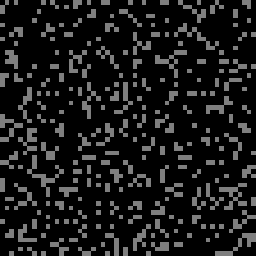

In [53]:
targets_vis = torch.zeros(layer_to_vis.output_shape())
targets_vis.view(-1)[targets.unique() - layer_to_vis.n_lookup_neurons()] = 0.5
to_pil_image(targets_vis.unsqueeze(0)).resize(
    [256, 256], Image.NEAREST
).show()

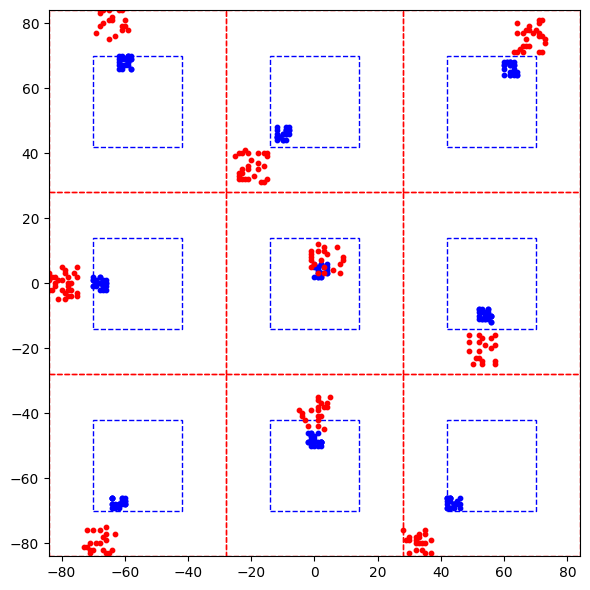

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

input_shape = layer_to_vis.input_shape()
output_shape = layer_to_vis.output_shape()

plot_rectangle = (max(input_shape[0], output_shape[0]), max(input_shape[1], output_shape[1]))

iy = (torch.arange(input_shape[0], device=device) - input_shape[0] / 2) # * (plot_rectangle[0] / input_shape[0])
ix = (torch.arange(input_shape[1], device=device) - input_shape[1] / 2) # * (plot_rectangle[1] / input_shape[1])
grid_iy, grid_ix = torch.meshgrid(iy, ix, indexing='ij')
grid_iy = grid_iy.flatten()
grid_ix = grid_ix.flatten()

oy = (torch.arange(output_shape[0], device=device) - output_shape[0] / 2) # * (plot_rectangle[0] / output_shape[0])
ox = (torch.arange(output_shape[1], device=device) - output_shape[1] / 2) # * (plot_rectangle[1] / output_shape[1])
grid_oy, grid_ox = torch.meshgrid(oy, ox, indexing='ij')
grid_oy = grid_oy.flatten()
grid_ox = grid_ox.flatten()

plt.close()
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim((-plot_rectangle[1] / 2) * grid_side, (plot_rectangle[1] / 2) * grid_side)
ax.set_ylim((-plot_rectangle[0] / 2) * grid_side, (plot_rectangle[0] / 2) * grid_side)

anchors = layer_to_vis._detector_anchors.reshape(layer_to_vis._n_detector_groups, -1).cpu()
for i in range(grid_side):
    for j in range(grid_side):
        center_x_shift = plot_rectangle[1] * (j - (grid_side / 2) + 0.5)
        center_y_shift = plot_rectangle[0] * ((grid_side / 2) - i - 0.5)
        rect = patches.Rectangle(
            (
                center_x_shift - output_shape[1] / 2,
                center_y_shift - output_shape[0] / 2
            ), output_shape[1], output_shape[0],
            fill=False, linestyle="--", linewidth=1, edgecolor="red"
        )
        ax.add_patch(rect)
        rect = patches.Rectangle(
            (
                center_x_shift - input_shape[1] / 2,
                center_y_shift - input_shape[0] / 2
            ), input_shape[1], input_shape[0],
            fill=False, linestyle="--", linewidth=1, edgecolor="blue"
        )
        ax.add_patch(rect)
        sample_id = sample_ids[i * grid_side + j]
        ys = -grid_iy[anchors[sample_id]] + center_y_shift
        xs = grid_ix[anchors[sample_id]] + center_x_shift
        ax.scatter(xs.cpu().numpy(), ys.cpu().numpy(), c="blue", s=10, label="set 1")
        ys = -grid_oy[sources_to_vis[sample_id * n_sources_per_detectors_group]] + center_y_shift
        xs = grid_ox[sources_to_vis[sample_id * n_sources_per_detectors_group]] + center_x_shift
        ax.scatter(xs.cpu().numpy(), ys.cpu().numpy(), c="red",  s=10, label="set 2")
plt.tight_layout()
plt.show()


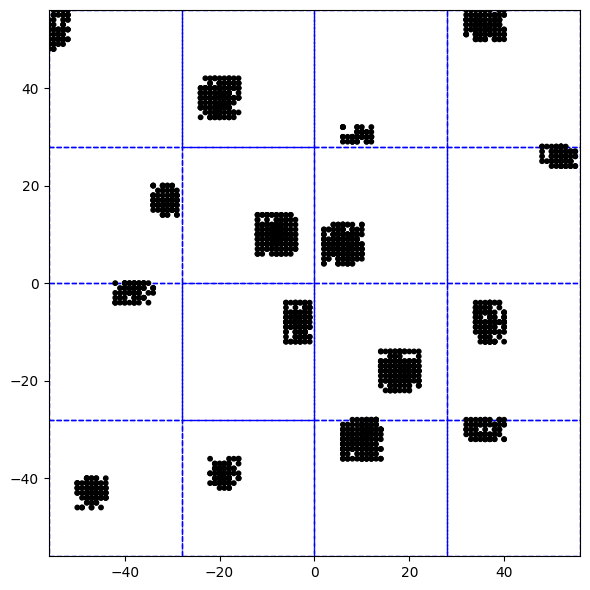

In [55]:
grid_side = 4
unique_targets = targets.unique()
targets_to_vis = unique_targets[torch.randperm(unique_targets.numel())][:grid_side**2].cpu()

anchors = layer_to_vis._detector_anchors.reshape(
    layer_to_vis._n_detector_groups * layer_to_vis._n_detectors_in_group, -1
).cpu()
sources_to_vis = {targets_to_vis[i].item(): dict() for i in range(grid_side**2)}

for s, t in zip(sources.cpu().numpy(), targets.cpu().numpy()):
    d = sources_to_vis.get(t)
    if d is not None:
        detector_id = s // LUTLayerBasic.n_lut_channels(layer_to_vis._n_anchors_per_detector, 1)
        if detector_id not in d:
            d[detector_id] = anchors[detector_id]

for t, d in sources_to_vis.items():
    sources_to_vis[t] = torch.cat(list(d.values())).cpu()

targets_to_vis = list(sources_to_vis.keys())
sources_to_vis = list(sources_to_vis.values())
colors_to_vis = [torch.zeros_like(s, dtype=torch.float32).unsqueeze(1).repeat(1, 3).cpu() for s in sources_to_vis]

input_shape = layer_to_vis.input_shape()

iy = (torch.arange(input_shape[0], device=device) - input_shape[0] / 2) # * (plot_rectangle[0] / input_shape[0])
ix = (torch.arange(input_shape[1], device=device) - input_shape[1] / 2) # * (plot_rectangle[1] / input_shape[1])
grid_iy, grid_ix = torch.meshgrid(iy, ix, indexing='ij')
grid_iy = grid_iy.flatten()
grid_ix = grid_ix.flatten()
plt.close()

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim((-input_shape[1] / 2) * grid_side, (input_shape[1] / 2) * grid_side)
ax.set_ylim((-input_shape[0] / 2) * grid_side, (input_shape[0] / 2) * grid_side)

for i in range(grid_side):
    for j in range(grid_side):
        center_x_shift = input_shape[1] * (j - (grid_side / 2) + 0.5)
        center_y_shift = input_shape[0] * ((grid_side / 2) - i - 0.5)
        rect = patches.Rectangle(
            (
                center_x_shift - input_shape[1] / 2,
                center_y_shift - input_shape[0] / 2
            ), input_shape[1], input_shape[0],
            fill=False, linestyle="--", linewidth=1, edgecolor="blue"
        )
        ax.add_patch(rect)
        sample_id = i * grid_side + j
        ys = -grid_iy[sources_to_vis[sample_id]] + center_y_shift
        xs = grid_ix[sources_to_vis[sample_id]] + center_x_shift
        ax.scatter(xs.cpu().numpy(), ys.cpu().numpy(), c=colors_to_vis[sample_id], s=10, label="set 1")
plt.tight_layout()
plt.show()

tensor(0.2670, device='cuda:5', grad_fn=<MulBackward0>)


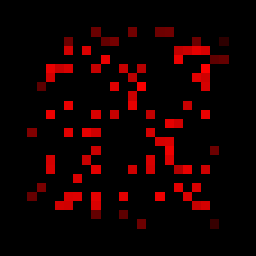

In [56]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue

lut_conv_net(example_data)
l = lut_conv_net._l2_res[6]

img = grayscale_to_red_and_blue(l, do_clip=False)
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
print(color_rescaler)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        256, 256
    ], Image.NEAREST
)

tensor(2.8300e-05, device='cuda:5')


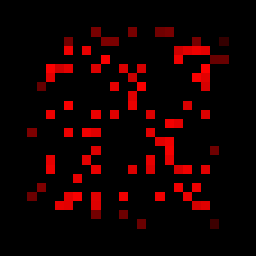

In [57]:
average_l = torch.zeros((1,) + lut_conv_net.layer2.output_shape(), device=device)

lut_conv_net.eval()
correct = 0
with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
    for data, target in test_loader:
        lut_conv_net(data)
        average_l += lut_conv_net._l2_res.sum(dim=0)
        
l = average_l
img = grayscale_to_red_and_blue(l, do_clip=False)
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
print(color_rescaler)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        256, 256
    ], Image.NEAREST
)

In [58]:
train_accuracies = []
test_accuracies = []

In [59]:
optimizer = torch.optim.Adam(lut_conv_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=8,
    gamma=0.1
)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    lut_conv_net.train()
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = lut_conv_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    lut_conv_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = lut_conv_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(
        f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}, '
        f'mean weights norm, layer 1: {mean_weights_norm(lut_conv_net.layer1):.5f}, '
        f'mean weights norm, layer 2: {mean_weights_norm(lut_conv_net.layer2):.5f}, '
        f'lr: {scheduler.get_last_lr()}'
    )
    scheduler.step()

Epoch 1 Train/test accuracy: 91.75/97.11, mean weights norm, layer 1: 1.00496, mean weights norm, layer 2: 3.20492lr: [0.001]
Epoch 2 Train/test accuracy: 98.02/97.78, mean weights norm, layer 1: 1.10835, mean weights norm, layer 2: 3.63783lr: [0.001]
Epoch 3 Train/test accuracy: 98.90/97.88, mean weights norm, layer 1: 1.19049, mean weights norm, layer 2: 3.96031lr: [0.001]
Epoch 4 Train/test accuracy: 99.45/98.06, mean weights norm, layer 1: 1.25692, mean weights norm, layer 2: 4.21386lr: [0.001]
Epoch 5 Train/test accuracy: 99.73/98.04, mean weights norm, layer 1: 1.31133, mean weights norm, layer 2: 4.42619lr: [0.001]
Epoch 6 Train/test accuracy: 99.78/97.99, mean weights norm, layer 1: 1.36903, mean weights norm, layer 2: 4.62524lr: [0.001]
Epoch 7 Train/test accuracy: 99.76/97.82, mean weights norm, layer 1: 1.43112, mean weights norm, layer 2: 4.82003lr: [0.001]
Epoch 8 Train/test accuracy: 99.79/98.21, mean weights norm, layer 1: 1.48784, mean weights norm, layer 2: 5.00049lr: 

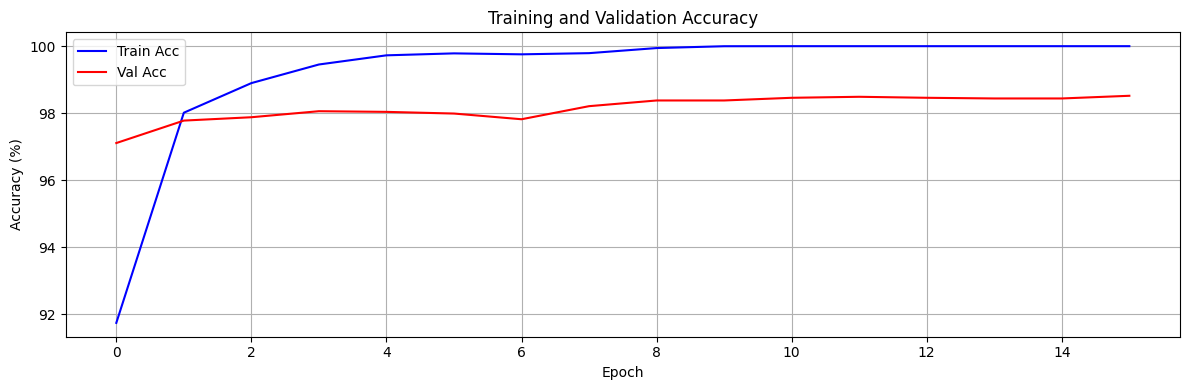

Best validation accuracy: 98.52% at epoch 16


In [61]:
# Plot training curves
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 4))

# Accuracy plot
ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(test_accuracies, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(test_accuracies):.2f}% at epoch {test_accuracies.index(max(test_accuracies))+1}")
